https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

# Постановка задачи
Необходимо обучить модель на истории торгов, чтобы предсказать будущю доходность: $\frac{Clsoe(t+2) - Close(t+1)}{Close(t+1)}$, где t - текущий день.

Далее мы отранжируем компании по прогнозированным доходностям и посчитаем коэффициент Шарпа (инвестиционная эффективность)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт библиотек

In [ ]:
import os
import random

# Базовые библиотеки для анализа данных
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import datetime as dt

# Библиотеки для визуализации
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Утилиты для решения задачи машинного обучения
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import geometric_mean_relative_absolute_error as gmrae
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    r2_score
)

# Реализация градиентного бустинга над решающими деревьями от LightGBM
from lightgbm import LGBMRegressor, plot_metric

# Игнорирование предупреждений
import warnings

#Config
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')

# Импорт данных

In [108]:
# Основной файл
df_prices = pd.read_csv('/content/drive/MyDrive/StockPrice/data/stock_prices.csv'); df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.000000,576.000000,563.000000,571.000000,2798500,1.000000,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.000000,3210.000000,3140.000000,3210.000000,270800,1.000000,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.000000,1550.000000,1510.000000,1550.000000,11300,1.000000,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.000000,3350.000000,3270.000000,3330.000000,150800,1.000000,NaN,False,0.003026


In [109]:
# Пример решения
sample = pd.read_csv("/content/drive/MyDrive/StockPrice/data/sample_submission.csv"); sample.head()

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4


In [110]:
# Информация о компаниях
stock_list = pd.read_csv("/content/drive/MyDrive/StockPrice/data/stock_list.csv"); stock_list.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.000000,3080.000000,10928283.000000,33659111640.000000,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.000000,2097.000000,3634635625.000000,7621830905625.000000,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.000000,2073.500000,7917718452.000000,16417389210222.000000,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.000000,2053.000000,3736943486.000000,7671944976758.000000,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.000000,44280.000000,72632.000000,3216144960.000000,False


# 2) Предварительный анализ данных.



## 2.1. Обзор набора данных.
В данной курсовой работе будет использоваться набор данных «JPX Tokyo Stock Exchange Prediction» [1], содержащий историю торгов на японской бирже. Всего в датасете 2 332 531 торгов.

Основной файл, содержащий дневную цену закрытия для каждой акции и столбец с целевой переменной. Далее представлена информация о столбцах, описанных в `stock_price_spec.csv`:

* `RowId`: Уникальный ID записей о ценах, комбинация `Date` и `SecuritiesCode`.
* `Date`: Дата торгов.
* `SecuritiesCode`: Локальный код ценной бумаги.
* `Open`: Цена открытия акции в этот день.
* `High`: Максимальная цена акции за день.
* `Low`: Минимальная цена акции за день.
* `Close`: Цена закрытия акции в этот день.
* `Volume`: Объем торгуемых акций за день.
* `AdjustmentFactor`: Используется для расчета теоретической цены/объема при дроблении/обратном дроблении акций (НЕ включая дивиденды/распределение акций).
* `ExpectedDividend`: Ожидаемая величина дивидендов на текущую дату. Это значение регистрируется за 2 рабочих дня до даты выплаты дивидендов.
* `SupervisionFlag`: Флаг ценных бумаг, находящихся под надзором, и ценных бумаг, подлежащих исключению из списка.
* `Target`: Изменение соотношения скорректированной цены закрытия между t+2 и t+1, где t+0 - дата сделки.

In [ ]:
# 5 первых строк основного файла с торгами
df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.000000,576.000000,563.000000,571.000000,2798500,1.000000,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.000000,3210.000000,3140.000000,3210.000000,270800,1.000000,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.000000,1550.000000,1510.000000,1550.000000,11300,1.000000,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.000000,3350.000000,3270.000000,3330.000000,150800,1.000000,NaN,False,0.003026


## 2.2. Пропущенные значения.

В столбце ожидаемых дивидендов самый большой процент пропущенных значений, это объясняется тем, что подавляющая часть компаний не выплачивают дивидендов. При такой большей доле пропущенных значений принято удалять столбец, но выплата дивидендов достаточно сильно влияет на цену/доходность акций, поэтому я решил заполнить пропущенные значениями нулями.

In [ ]:
# Получаем доли пропущенных значений в столбцах
nan_ratio = pd.isna(df_prices).sum() / len(df_prices) * 100
# Сортируем доли пропущенных значений по убыванию
nan_ratio.sort_values(ascending=False, inplace=True)
# Переводим в формат таблицы
nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
# Выводим полученные данные
display(nan_ratio)  

,ExpectedDividend,Open,High,Low,Close,Target,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,SupervisionFlag
NaN Ratio,99.191222,0.326169,0.326169,0.326169,0.326169,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Так же заметно, что цены открытия, закрытия, максимальные и минимальные цены имеют равные доли пропущенных значений. На графике снизу заметно, что вышеперечисленные пропуски произошли в один день. Это было 1 октября 2020 года, на токийской бирже происходили технические сбои. Данные пропущенные значения не следует заменять, поэтому я удалю строки с пропущенными ценами.

In [ ]:
# Создаем новую таблицу, где цена закрытия пропущена, это нужно для анализа пропущенных значений
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Количество записей без цены: {len(df_no_prices)}")

Количество записей без цены: 7608


In [ ]:
# Получаем новые данные: пропущенные цены по дням
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
# Убираем дубликаты дат
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

# Визуализируем
fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Кол-во акций с пропущенными ценами по дням",
    xaxis_title="День",
    yaxis_title="Кол-во акций",
)
fig.show()

In [ ]:
# Заполняем пропущенные дивиденды нулями
df_prices['ExpectedDividend'] = df_prices['ExpectedDividend'].fillna(0)
# Остальные пропущенные значения удаляем (строки)
df_prices = df_prices.dropna()
# Проверяем остались ли пропущенные значения в данных (не осталось)
df_prices.isnull().sum()

RowId               0
Date                0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Target              0
dtype: int64

## 2.3. Описательный анализ целевой переменной.

Таблица снизу с вычисленными описательными статистиками. Можно отметить, что столбец целевой переменной имеет довольно сильный разброс: стандартное отклонение больше среднего значения более чем в 53 раза.

In [ ]:
# вывод описателньых статистик
df_prices.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000
mean,5895.573280,2594.510783,2626.539682,2561.227039,2594.023446,694200.826522,1.000508,0.178403,0.000426
std,2403.239110,3577.191909,3619.363218,3533.494080,3576.538402,3917449.627097,0.067788,3.335642,0.023392
min,1301.000000,14.000000,15.000000,13.000000,14.000000,100.000000,0.100000,0.000000,-0.578541
25%,3891.000000,1022.000000,1035.000000,1009.000000,1022.000000,30700.000000,1.000000,0.000000,-0.010526
50%,6240.000000,1812.000000,1834.000000,1790.000000,1811.000000,107900.000000,1.000000,0.000000,0.000000
75%,7965.000000,3030.000000,3070.000000,2995.000000,3030.000000,404100.000000,1.000000,0.000000,0.010526
max,9997.000000,109950.000000,110500.000000,107200.000000,109550.000000,643654000.000000,20.000000,1070.000000,0.618238


Коэффициент эксцесса средних значений равен 10.54, что больше, чем у нормального распределения более чем в три раза. Из этого можно сделать вывод, что на фондовом рынке было много колебаний цены и в будущем инвесторы могут столкнуться с высокой волатильностью. 


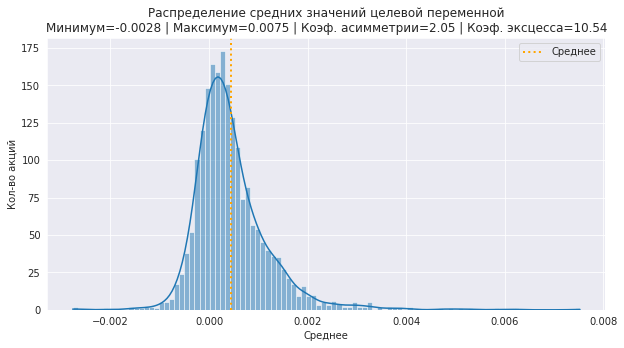

In [ ]:
# Получаем средние доходности каждой компании
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()

# Получаем среднюю от средних доходностей компаний
target_mean_mean = target_mean_per_stock.mean()

# Визуализируем распределение средних доходностей
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Распределение средних значений целевой переменной\n"
             f"Минимум={round(target_mean_per_stock.min(), 4)} | "
             f"Максимум={round(target_mean_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_mean_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Среднее")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Распределение стандартных отклонений доходностей имеет эксцесс 2.11, что меньше, чем у нормального распределения. Можно сделать вывод, что стандартные отклонения целевой переменной имеют маленький разброс. Но если смотреть на абсолютные величины отклонений, то они в разы больше средних.

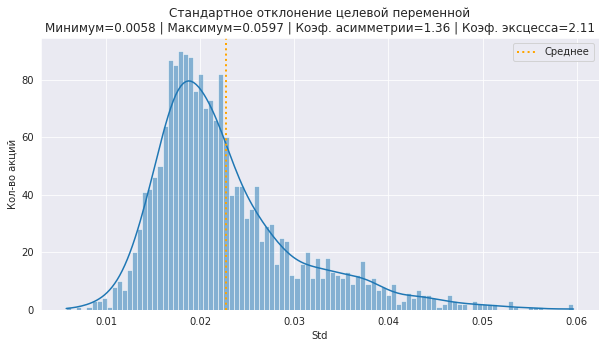

In [ ]:
# Получаем стандартные отклонения доходностей каждой компании
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()

# Получаем среднее от стандартных доходностей
target_std_mean = target_std_per_stock.mean()

# Визуализируем график
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Стандартное отклонение целевой переменной\n"
             f"Минимум={round(target_std_per_stock.min(), 4)} | "
             f"Максимум={round(target_std_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_std_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Std")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

## 2.4. Описательный анализ компаний/фондов и секторов.

На графике представлены топ 10 компаний или фондов по рыночной капитализации. Первое место занимает индекс S&P500 – индекс, состоящий из 500 крупнейших компаний США. На втором и третьем месте всемирно известные Toyota и Sony. 

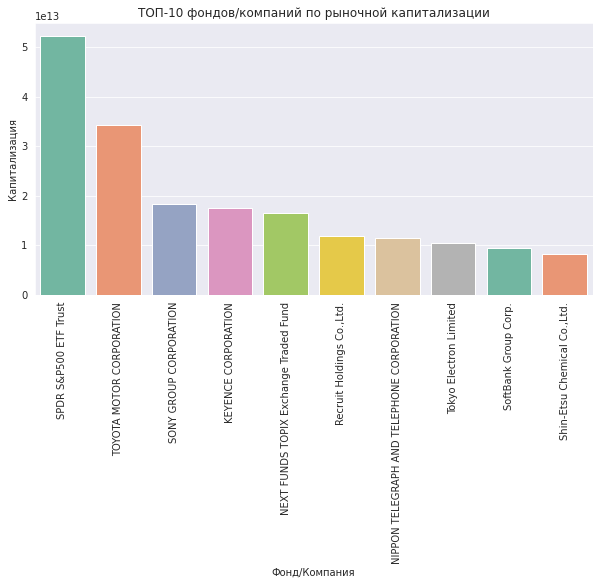

In [ ]:
# Сортируем компании по рыночной капитализации по убыванию
top_by_cap = stock_list.sort_values('MarketCapitalization', ascending=False)[['Name','MarketCapitalization']][:10]

# Визуализируем топ 10 компаний
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_by_cap['Name'].values, y=top_by_cap['MarketCapitalization'].values, 
            palette=colors, ax=ax)
ax.set_title("ТОП-10 фондов/компаний по рыночной капитализации")
ax.set_xlabel("Фонд/Компания")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Капитализация")
plt.show()


Акции на японской бирже разделяются на 4 секций:
1.	First Section – акции компаний с большой рыночной капитализацией
2.	Second Section – акции компаний со средней рыночной капитализацией
3.	Mothers и JASDAQ – акции стартапов
4.	Tokyo Pro market – специальная секция для профессиональных инвесторов

Так же акции могут быть:
1.	Domestic – акции японских компаний
2.	Foreign – акции иностранных компаний
3.	Growth – акции с высоким потенциалом. Данные акции несут высокий риск, но имеют больше среднего доходность


Как видно диаграмме ниже на японском фондовом рынке преобладает секция японских компаний с высокой рыночной капитализацией, далее идет секция японских стартапов. 

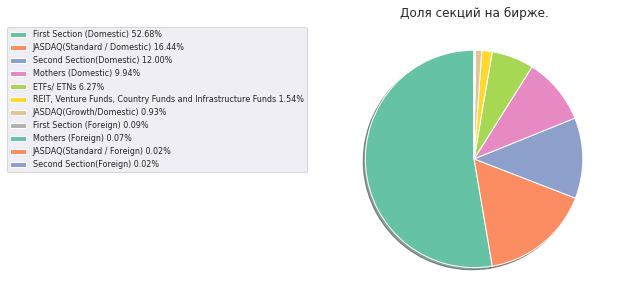

In [ ]:
# Получаем информацию о секциях и кол-во акциях в этих секциях 
sec_prod_val_cnt = stock_list['Section/Products'].value_counts()

# Вычисляем доли секций
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
# Названия секций
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

# Визуализируем
fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Доля секций на бирже.")
plt.show()

На диаграмме снизу представлены доля секций для топ 2000 акций по рыночной капитализации.

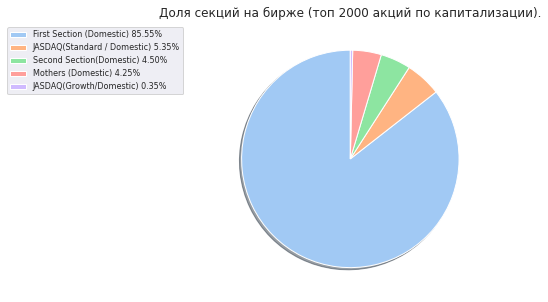

In [ ]:
# Отделяем наши целевые компании (топ 2000 компаний по рыночной капитализации) дял анализа секций
target_stock_list = stock_list[stock_list['Universe0']]

# Получаем информацию о секциях и кол-во акциях в этих секциях 
sec_prod_val_cnt = target_stock_list['Section/Products'].value_counts()

# Вычисляем доли секций
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100

# Названия секций
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

# Визуализируем
fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Доля секций на бирже (топ 2000 акций по капитализации).")
plt.show()

На диаграмме снизу изображено распределение секторов среди тех же 2000 акций. Больше всего компаний из IT сектора, сферы услуг и ретейлинга.

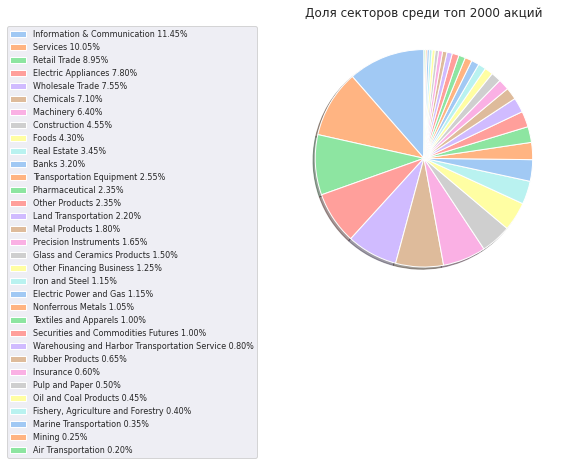

In [ ]:
# Отделяем наши целевые компании (топ 2000 компаний по рыночной капитализации) дял анализа секторов
target_stock_list = stock_list[stock_list['Universe0']]

# Получаем информацию о секторах и кол-во акциях в этих секторах 
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()

# Вычисляем доли секторов
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100

# Получаем названия секторов
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

# Визуализируем сектора
fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Доля секторов среди топ 2000 акций")
plt.show()

На графике снизу изображёно распределение средних доходностей по секторам. Морские грузоперевозки в среднем имеют самую высокую доходность. Акции банком же в среднем имеют отрицательную доходность.

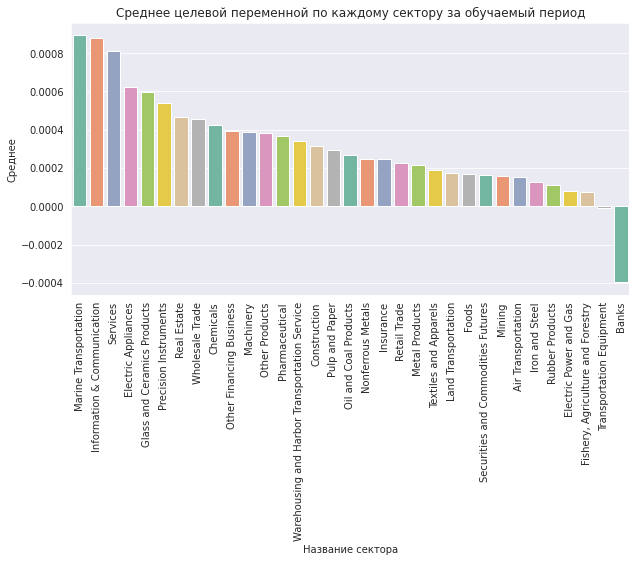

In [ ]:
# Получаем информацию о секторах и объединяем с основной таблицей
sec_info = target_stock_list[['SecuritiesCode', '33SectorName', '33SectorCode', '17SectorCode', '17SectorName']]
df_prices = pd.merge(df_prices, sec_info, on='SecuritiesCode')
df_prices.head()

# Расчитываем средние доходностти по секторам
target_mean_33sec = df_prices.groupby(['33SectorName'])['Target'].mean()
target_mean_33sec.sort_values(inplace=True, ascending=False)

# Визуализируем
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_33sec.index, y=target_mean_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по каждому сектору за обучаемый период")
ax.set_xlabel("Название сектора")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Среднее")
plt.show()

Все компании морских перевозок имеют среднюю доходность выше нуля

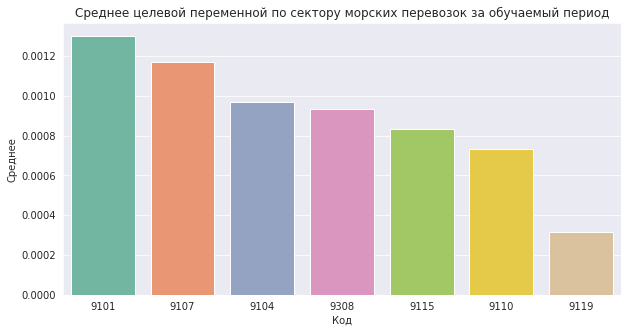

In [ ]:
# Получаем информацию о морских грузоперевозках
target_sector = 'Marine Transportation'
df_prices_marine = df_prices[df_prices['33SectorName'] == target_sector]

# Вычисляем средние доходности компаний из этого сектора и сортируем
target_mean_marine = df_prices_marine.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_marine.sort_values(inplace=True, ascending=False)

# Визуализируем средние доходности комапний из морских грузоперевозок
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_marine.index, y=target_mean_marine.values, 
            order=target_mean_marine.index, palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по сектору морских перевозок за обучаемый период")
ax.set_xlabel("Код")
ax.set_ylabel("Среднее")
plt.show()

Построим такой же график для банковского сектора – худшего сектора по доходности. Большинство акций из банковского сектора имеют в среднем отрицательную доходность, только 4 банка имеют положительные показатели.

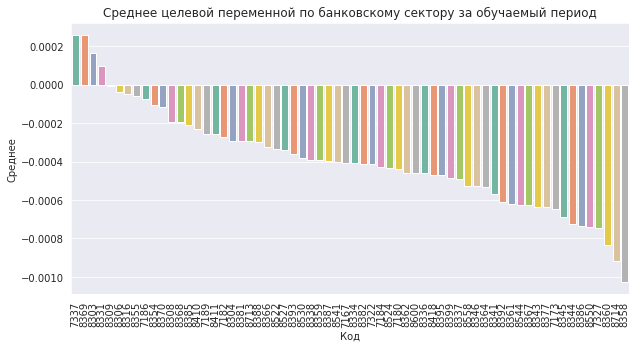

In [ ]:
# Получаем информацию о банках
target_sector = 'Banks'
df_prices_banks = df_prices[df_prices['33SectorName'] == target_sector]

# Вычисляем средние доходности компаний из банковского сектора и сортируем
target_mean_banks = df_prices_banks.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_banks.sort_values(inplace=True, ascending=False)

# Визуализируем средние доходности банкоского сектора
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_banks.index, y=target_mean_banks.values, 
            order=target_mean_banks.index, palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по банковскому сектору за обучаемый период")
ax.set_xlabel("Код")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Среднее")
plt.show()

На рисунке снизу можно увидеть, как ведет себя целевая переменная у худших банков по средней доходности.

In [ ]:
# Визуализируем доходности топ 3 худших банков
fig = go.Figure()
for stock_code in [8360, 8714, 8358]:
    df_ = df_prices_banks[df_prices_banks['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=df_.Date.unique(), y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Графики целевой переменной среди топ-3 худших компаний в банковском секторе",
)
fig.show()

# 3) Добавление и отбор признаков.

## 3.1. Доходность
Добавим в выборку новые признаки:
1)	Доходность акции за 20 торговых дней
2)	Доходность акции за 40 торговых дней
3)	Доходность акции за 60 торговых дней

Доходность даст дополнительную техническую информацию об акции. 
(Примечание: мы предсказываем будущую доходность, новые признаки же вычисляются на основе прошлых данных). На рисунке снизу изображен пример новых данных.


In [ ]:
def plot_return(stock_code):
    # stock_code - код компании
    # Визуализация доходности компании за разные периоды
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [20, 40, 60] # торговые периоды
    cols = []

    for period in periods:
        col = f"Доходность {period // 20} месяц(-а)"
        df_[col] = df_["Close"].pct_change(period)
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Доходность, акция {stock_code}', height = 350)
    fig.show()
    
N = random.randint(0, 1997)
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_return(stock_code)

## 3.2. Волатильность.

Так же добавим стандартную волатильность акции в обучающую выборку. Волатильность будет рассчитываться как стандартное отклонение цены закрытия за определенный период. На рисунке снизу пример новых данных.


In [ ]:
def plot_volatility(stock_code):
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [5, 25, 75]
    cols = []

    for period in periods:
        col = f"Волатильность с окном {period}"
        df_[col] = np.log(df_["Close"]).diff().rolling(period).std()
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Волатильность')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Волатильность, акция {stock_code}', height = 350)
    fig.show()
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_volatility(stock_code)

## 3.3. Скользящая средняя.
Добавлю новые признаки на основе простой скользящей средней, а именно отношение цены закрытия к простым скользящим разных периодов. На рисунке снизу пример скользящей средней разных периодов для 3 акции.


In [ ]:
def plot_moving_average(stock_code):
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [5, 15, 25]
    cols = []

    for period in periods:
        col = f"Простое скользящее среднее с окном {period}"
        df_[col] = df_["Close"].rolling(period, min_periods=1).mean()
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Скользящее среднее, акция {stock_code}', height = 350)
    fig.show()
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_moving_average(stock_code)

Добавляем вышеперечисленные признаки

In [ ]:
def get_features_for_predict(price, code, start_dt=pd.Timestamp(2017, 3, 1)):
    df_ = df_prices.copy()
    
    feats = df_[df_.SecuritiesCode == code]
    feats['Date'] = pd.to_datetime(feats['Date'])
    feats = feats.select_dtypes(include=["float64","int64", "datetime64"])
    
    # Доходность, изменение цены закрытия за 20 рабочих дней
    feats["return_1month"] = feats["Close"].pct_change(20)
    # Доходность, изменение цены закрытия за 40 рабочих дней
    feats["return_2month"] = feats["Close"].pct_change(40)
    # Доходность, изменение цены закрытия за 60 рабочих дней
    feats["return_3month"] = feats["Close"].pct_change(60)
    # волатильность за 20 дней
    feats["volatility_1month"] = (
        np.log(feats["Close"]).diff().rolling(20).std()
    )
    # волатильность за 40 дней
    feats["volatility_2month"] = (
        np.log(feats["Close"]).diff().rolling(40).std() 
    )
    # волатильность за 60 дней
    feats["volatility_3month"] = (
        np.log(feats["Close"]).diff().rolling(60).std()
    )
    # Разница между ценой закрытия и 20-дневной простой скользящей средней
    feats["MA_gap_1month"] = feats["Close"] / (
        feats["Close"].rolling(20).mean()
    )
    # Разница между ценой закрытия и 40-дневной простой скользящей средней
    feats["MA_gap_2month"] = feats["Close"] / (
        feats["Close"].rolling(40).mean()
    )
    # Разница между ценой закрытия и 60-дневной простой скользящей средней
    feats["MA_gap_3month"] = feats["Close"] / (
        feats["Close"].rolling(60).mean()
    )
    
    #Фильтрация с указанного дня
    feats = feats.loc[feats.Date > start_dt] #

    return feats

In [ ]:
%%time
# Получаем коды компаний
codes = df_prices.SecuritiesCode.unique()

# Добавляем признаки
df_prices_new = get_features_for_predict(df_prices, codes[0])

# Обновляем признаки для каждой компании и объединяем все в одну таблицу
for code in tqdm(codes[1:]):
    df_prices_new = pd.concat([df_prices_new, get_features_for_predict(df_prices, code)])
df_prices_new = df_prices_new.sort_values(by=['Date', 'SecuritiesCode']).reset_index().drop(["index"], axis=1).fillna(0)
df_prices_new

  0%|          | 0/1999 [00:00<?, ?it/s]

CPU times: user 9min 33s, sys: 12.2 s, total: 9min 46s
Wall time: 10min 22s


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month
0,2017-03-02,1301,3030.000000,3035.000000,3015.000000,3020.000000,52500,1.000000,0.000000,0.023026,0.106632,0.101386,0.000000,0.005480,0.005780,0.000000,1.060803,1.083991,0.000000
1,2017-03-02,1332,565.000000,568.000000,562.000000,567.000000,3055100,1.000000,0.000000,-0.022928,0.048059,-0.007005,0.000000,0.022672,0.021129,0.000000,0.994475,1.012410,0.000000
2,2017-03-02,1333,3415.000000,3435.000000,3390.000000,3400.000000,241900,1.000000,0.000000,0.011577,0.093248,0.059190,0.000000,0.016400,0.014191,0.000000,1.025023,1.045872,0.000000
3,2017-03-02,1376,1480.000000,1480.000000,1470.000000,1471.000000,3100,1.000000,0.000000,0.004785,0.010302,-0.050968,0.000000,0.007906,0.009649,0.000000,1.016410,0.993869,0.000000
4,2017-03-02,1377,3205.000000,3245.000000,3190.000000,3235.000000,116000,1.000000,0.000000,-0.004644,0.006221,-0.028529,0.000000,0.010633,0.014874,0.000000,1.014902,1.000928,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250547,2021-12-03,9990,514.000000,528.000000,513.000000,528.000000,44200,1.000000,0.000000,0.034816,-0.147011,-0.062167,-0.052065,0.022620,0.022582,0.020410,0.935424,0.937375,0.934899
2250548,2021-12-03,9991,782.000000,794.000000,782.000000,794.000000,35900,1.000000,0.000000,0.025478,-0.034063,-0.082081,-0.119734,0.015520,0.015145,0.013716,0.987869,0.947353,0.923471
2250549,2021-12-03,9993,1690.000000,1690.000000,1645.000000,1645.000000,7200,1.000000,0.000000,-0.004302,-0.043048,-0.046377,-0.056225,0.006163,0.006260,0.007898,0.964555,0.962284,0.955238
2250550,2021-12-03,9994,2388.000000,2396.000000,2380.000000,2389.000000,6500,1.000000,0.000000,0.009098,-0.026487,-0.012402,-0.054236,0.007357,0.007663,0.008449,0.996538,0.993688,0.978557


## 3.4. Временные признаки.
В выборку добавлены следующие временные признаки:
1)	Год
2)	Месяц
3)	День недели


In [ ]:
df_prices_new['Day'] = df_prices_new['Date'].dt.day
df_prices_new['Month'] = df_prices_new['Date'].dt.month
df_prices_new['Year'] = df_prices_new['Date'].dt.year

## 3.5. Сглаживание цены закрытия 

Так же применю экспоненциальную скользящую среднюю к цене закрытия, она сгладит цену и ослабит влияние выбросов. На рисунке снизу можно увидеть результат обработки.

In [29]:
def smoothen_ema(data, code, period=15):
  # Экспоненциальная скользящая средняя
  df_ = data[data['SecuritiesCode'] == code]
  df_['Close'] = df_["Close"].ewm(span=period, adjust=False).mean()
  df_["Target"] = (df_["Close"].shift(-2) - df_["Close"].shift(-1)) / df_["Close"].shift(-1)
  return df_

# Получаем коды компаний
codes = df_prices_new['SecuritiesCode'].unique()

# Применяем экспоненциальную скользящую среднюю к цене знакрытия для каждой компании
# И объединяем в одну таблицу
df_prices_smooth_ema = smoothen_ema(df_prices_new, codes[0])
for code in tqdm(codes[1:]):
    df_prices_smooth_ema = pd.concat([df_prices_smooth_ema, smoothen_ema(df_prices_new, code)])
df_prices_smooth_ema = df_prices_smooth_ema.sort_values(by=['Date', 'SecuritiesCode']).reset_index().drop(["index"], axis=1).dropna()

  0%|          | 0/1999 [00:00<?, ?it/s]

In [30]:
def plot_closing_price(data, stock_code):
  # Визуализация цены закрытия и сглаженной цены закрытия
  df_ = data[data['SecuritiesCode'] == stock_code]
  df_['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
  
  fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

  fig.add_trace( 
      go.Scatter(
          x = df_['Date'],
          y = df_['Close'],
      )
  )
  fig.update_layout(template = 'presentation', title = f'Цена закрытия, акция {stock_code}', height = 350)
  fig.show()

# Визуализация
plot_closing_price(df_prices_new, 9733)
plot_closing_price(df_prices_smooth_ema, 9733)

In [31]:
# Переводим дату в нужный формат
df_prices_smooth_ema['Date'] = pd.to_datetime(df_prices_smooth_ema['Date'])
df_prices_smooth_ema['Date'] = df_prices_smooth_ema['Date'].dt.strftime("%Y%m%d").astype(int)

# 4) Построение модели

В данной курсовой работе используется реализация градиентного бустинга над решающими деревьями от LightGBM. Стоит так же отметить, что алгоритм градиентного бустинга более устойчив к мультиколлинеарности чем линейные модели. Для обучения я использую среднеквадратичную ошибку. Для оптимального разбиения датасета и улучшения результатов используется кросс-валидация.

## 4.1. Обучение модели

Из таблицы создаем переменные X - матрица признаков и y - вектор ответов.

In [ ]:
# Определяемя X - матрица признаков, y - вектор целевой переменной(будущая доходность)
X = df_prices_smooth_ema.drop(['Target'], axis=1)
y = df_prices_smooth_ema['Target']

Генерируем тренировачные и тестовые выборки, разделяем по дате

In [ ]:
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

С помощью кросс валидации разделяем обучающую выборку на 5 одинаковых блоков. Затем обучаем модель на 4 блоках и тестируем на оставшемся блоке (валидационная выборка). Создаем так 5 уникальных выборок.

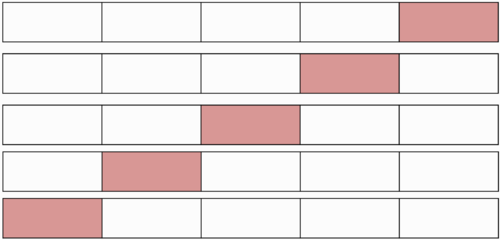

In [78]:
def setup_cv(df, splits=5):
    df['fold'] = -1
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(
        df["Target"], bins=num_bins, labels=False
    )

    kf = StratifiedKFold(n_splits=splits)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df.bins.values)):
            df.loc[v_, 'fold'] = f

    df = df.drop("bins", axis=1)
    return df

train_data = setup_cv(X.join(y))

Обучаем модели на получившихся выборках. Далее выберем лучшую модель.

In [79]:
def train_lgbm(prices, folds):
    models = list()
    
    for f in range(folds):
        X_train = prices[prices.fold != f].drop(['Target', 'fold'], axis=1)
        y_train = prices[prices.fold != f][["Target"]]
        X_valid = prices[prices.fold == f].drop(['Target', 'fold'], axis=1)
        y_valid = prices[prices.fold == f][["Target"]]
        
        model = LGBMRegressor()
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)], verbose=0)
        oof_preds = model.predict(X_valid)
        oof_score = np.sqrt(mean_squared_error(y_valid, oof_preds))
        print(f"Fold {f+1} RMSE: {oof_score}")
        models.append(model)
        
    return models

lgbm_models = train_lgbm(train_data, 5)

Fold 1 RMSE: 0.008534352638724537
Fold 2 RMSE: 0.008899594055260284
Fold 3 RMSE: 0.008451267659988451
Fold 4 RMSE: 0.009063519122419489
Fold 5 RMSE: 0.008553826714754352


Получим предсказания на тестовых данных

In [93]:
codes = X_test['SecuritiesCode'].unique()
model = lgbm_models[2]
y_pred_m = model.predict(X_test)

Расчитываем метрики

In [94]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'r2': r2_score(y_true=y_true, y_pred=y_pred),
    })

get_metrics(y_true=y_test, y_pred=y_pred_m)

mse   0.000018
mae   0.002406
r2    0.592471
dtype: float64

История обучения модели

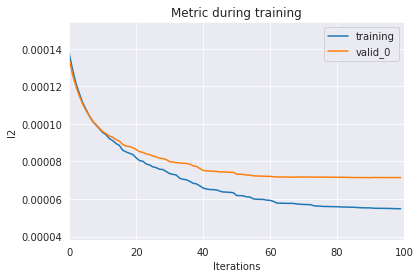

In [95]:
# Виазулизация mse во время обучения
plot_metric(model)

## 4.2. Предсказания модели.

выберем акцию для визуализации предсказаний

In [ ]:
stock_code = 9733

На графике снизу результаты предсказания целевой переменной

In [96]:
def plot_predictions(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    fig = make_subplots(x_title='Дата', y_title='Target')
    
    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df['Target'],
            name = 'Действительные'
        )
    )
    
    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df['Target_pred'],
            name = 'Предсказанные'
        )
    )
    
    
    fig.update_layout(template = 'presentation', title = f'Предсказание модели, акция {stock_code}', height = 350)
    fig.show()

plot_predictions(X_test, y_test, y_pred_m, stock_code=stock_code)

На графике снизу представлены реальные и предсказанные доходности. Предсказанные доходности рассчитываются на основе предсказанной целевеой переменной.

In [97]:
def plot_return_pred(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    N = len(df)
    df['Close_pred'] = 0
    df['Close_pred'].iloc[:2] = df['Close'].iloc[:2]
    for i in range(2, N):
        df['Close_pred'].iloc[i] = df['Close_pred'].iloc[i-1]*(df['Target_pred'].iloc[i-2]+1)
    
    
    periods = [20, 40, 60]

    for period in periods:
        fig = go.Figure()

        fig.add_trace( 
            go.Scatter(
                x = df['Date'],
                y = df["Close"].pct_change(period),
                name = 'Действительные'
            )
        )

        fig.add_trace( 
            go.Scatter(
                x = df['Date'],
                y = df["Close_pred"].pct_change(period),
                name = 'Предсказанные'
            )
        )
        
        fig.update_layout(template = 'presentation', title = f'Доходность за {period // 20} месяц(-а), акция {stock_code}', 
                          xaxis_title='Дата',yaxis_title='Изменение цены', height = 350)
        fig.show()

plot_return_pred(X_test, y_test, y_pred_m, stock_code=stock_code)

На графике снизу предсказанная цена, которая так же вычисляется на основе предсказанной целевой переменной.

In [98]:
def plot_pred_price(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    N = len(df)
    df['Close_pred'] = 0
    df['Close_pred'].iloc[:2] = df['Close'].iloc[:2]
    for i in range(2, N):
        df['Close_pred'].iloc[i] = df['Close_pred'].iloc[i-1]*(df['Target_pred'].iloc[i-2]+1)
    
    fig = go.Figure()

    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df["Close"],
            name = 'Действительные'
        )
    )

    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df["Close_pred"],
            name = 'Предсказанные'
        )
    )
        
    fig.update_layout(template = 'presentation', title = f'Цена, акция {stock_code}', 
                      xaxis_title='Дата',yaxis_title='Цена', height = 350)
    fig.show()

plot_pred_price(X_test, y_test, y_pred_m, stock_code=stock_code)

Отранжируем компании по доходности

In [99]:
submission = X[['Year', 'Month', 'Day', 'SecuritiesCode']]
cols = ['Date', 'SecuritiesCode', 'Target', 'Rank']
submission['Target'] = model.predict(X)
submission['Date'] = pd.to_datetime(submission[['Year', 'Month', 'Day']])
submission.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

In [100]:
df = X.join(y)

In [101]:
max_targets = pd.DataFrame(df.groupby(['SecuritiesCode'])['Target'].max()).reset_index()
max_targets = max_targets.merge(df[['SecuritiesCode', 'Target', 'Date']], on=['SecuritiesCode', 'Target'])

In [102]:
import time
submission = pd.DataFrame(submission.groupby('SecuritiesCode')['Target'].mean().sort_values(ascending=False))
Rank = np.arange(2000)
submission['Rank'] = Rank
submission = submission.merge(max_targets, on='SecuritiesCode')
submission['Date'] = submission['Date'].apply(lambda x: pd.to_datetime(f"{str(x)[:4]}-{str(x)[4:6]}-{str(x)[6:]}"))
submission.drop('Target_y', axis=1, inplace=True)
submission.rename(columns={'Target_x': 'Target'}, inplace=True)
submission = submission[cols]
submission.to_csv(f'submission{int(time.time())}.csv')

In [103]:
submission.head()

,Date,SecuritiesCode,Target,Rank
0,2020-06-16,7095,0.003295,0
1,2017-09-25,5918,0.002934,1
2,2018-09-21,6815,0.002885,2
3,2020-10-13,4051,0.002840,3
4,2020-04-15,4490,0.002803,4


In [104]:
def ranking_by_date(df, date):
  date_predict = df[df['Date'] == date]
  #date_predict['Target'] = model.predict(date_predict)
  #date_predict = date_predict[date_predict['Date'] == date]
  date_predict = date_predict.sort_values('Target', ascending=False)
  Rank = np.arange(len(date_predict))
  date_predict['Rank'] = Rank
  return date_predict


df_ = X.copy()
df_['Target'] = model.predict(X)
dates = df_['Date'].unique()

ranked_by_date = ranking_by_date(df_, dates[0])
for date in tqdm(dates[1:]):
    ranked_by_date = pd.concat([ranked_by_date, ranking_by_date(df_, date)])

  0%|          | 0/1158 [00:00<?, ?it/s]

Также посчитаем для модели коэффициент Шарпа ежедневной доходности. Доходность за один день учитывает 250 акций с самым высоким рейтингом (например, от 0 до 249) как купленные, а 250 акций с самым низким рейтингом (например, от 1999 до 1750) - как проданные. Ранжирование акций происходит исходя из их ожидаемого изменения цены через день (целевой переменной). Затем акции взвешиваются на основе их рангов, и общая доходность портфеля рассчитывается исходя из предположения, что акции были куплены на следующий день и проданы на следующий день после этого. Как видно из рисунка 39, коэффициент Шарпа равен 1.0474. Значения больше 1 считаются хорошим результатом.

In [105]:
def calc_spread_return_sharpe(df, portfolio_size = 250, toprank_weight_ratio = 2) -> float:
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

calc_spread_return_sharpe(ranked_by_date)

1.047452296476888

# Заключение

Большинство наборов данных, содержащих историю торгов, имеют ограниченное кол-во признаков. Это обычно дата и различные цены. То есть можно сказать, что данные признаки не очень информативны. В ходе этой работы я провел предварительный анализ признаков и целевой переменной. Построил новый релевантный набор данных. И решил задачу оценки актива. Для достижения вышеперечисленных задач я использовал различные инструменты: 
1.	NumPY – для различных расчетов 
2.	Pandas – для работы с табличными данными 
3.	Scikit-learn – полезные утилиты для машинного обучения
4.	LightGMB – реализация градиентного бустинга над решающими деревьями